In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 

2022-04-08 12:48:30.517128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-08 12:48:30.517213: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
TEST_SIZE = 0.1
RANDOM_STATE = 2018
NO_EPOCHS = 10
BATCH_SIZE = 128

IS_LOCAL = False

In [4]:
train_images = np.load('/home/ninju/Desktop/dl/project/japanese/kmnist-train-imgs.npz')['arr_0']
test_images = np.load('/home/ninju/Desktop/dl/project/japanese/kmnist-test-imgs.npz')['arr_0']
train_labels = np.load('/home/ninju/Desktop/dl/project/japanese/kmnist-train-labels.npz')['arr_0']
test_labels = np.load('/home/ninju/Desktop/dl/project/japanese/kmnist-test-labels.npz')['arr_0']

In [5]:
char_df = pd.read_csv('/home/ninju/Desktop/dl/project/japanese/kmnist_classmap.csv', encoding = 'utf-8')

In [6]:
print("KMNIST train shape:", train_images.shape)
print("KMNIST test shape:", test_images.shape)
print("KMNIST train shape:", train_labels.shape)
print("KMNIST test shape:", test_labels.shape)

KMNIST train shape: (60000, 28, 28)
KMNIST test shape: (10000, 28, 28)
KMNIST train shape: (60000,)
KMNIST test shape: (10000,)


The dimmension of the character set data file for KMNIST are:

In [7]:
print("KMNIST character map shape:", char_df.shape)

KMNIST character map shape: (10, 3)


In [8]:
char_df

,index,codepoint,char
0,0,U+304A,お
1,1,U+304D,き
2,2,U+3059,す
3,3,U+3064,つ
4,4,U+306A,な
5,5,U+306F,は
6,6,U+307E,ま
7,7,U+3084,や
8,8,U+308C,れ
9,9,U+3092,を


In [9]:
print('Percent for each category:',np.bincount(train_labels)/len(train_labels)*100)

Percent for each category: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


/home/ninju/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ninju/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12362 (\N{HIRAGANA LETTER O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ninju/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ninju/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12377 (\N{HIRAGANA LETTER SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ninju/miniconda3/lib/python3.9/site-packages/IPython/core/

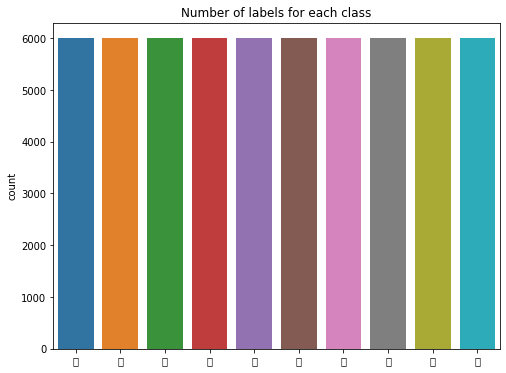

In [10]:
labels = char_df['char']
f, ax = plt.subplots(1,1, figsize=(8,6))
g = sns.countplot(train_labels)
g.set_title("Number of labels for each class")
g.set_xticklabels(labels)
plt.show()    

In [11]:
def plot_sample_images_data(images, labels):
    plt.figure(figsize=(12,12))
    for i in tqdm_notebook(range(10)):
        imgs = images[np.where(labels == i)]
        lbls = labels[np.where(labels == i)]
        for j in range(10):
            plt.subplot(10,10,i*10+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(imgs[j], cmap=plt.cm.binary)
            plt.xlabel(lbls[j])

/tmp/ipykernel_3673/3193316136.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(10)):


  0%|          | 0/10 [00:00<?, ?it/s]

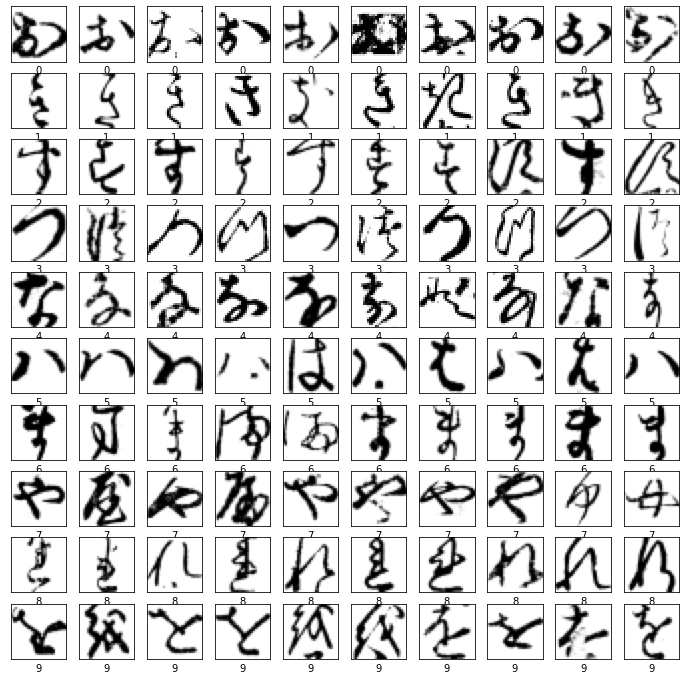

In [12]:
plot_sample_images_data(train_images, train_labels)

/tmp/ipykernel_3673/3193316136.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(10)):


  0%|          | 0/10 [00:00<?, ?it/s]

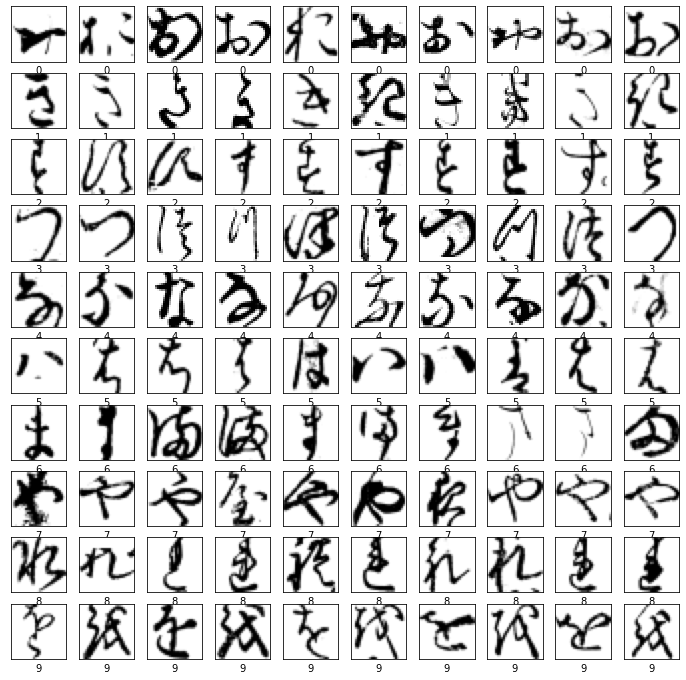

In [13]:
plot_sample_images_data(test_images, test_labels)

In [14]:
def data_preprocessing(images, labels):
    out_y = keras.utils.np_utils.to_categorical(labels, NUM_CLASSES)
    num_images = images.shape[0]
    x_shaped_array = images.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
    out_x = x_shaped_array / 255
    return out_x, out_y

In [15]:
X, y = data_preprocessing(train_images, train_labels)
X_test, y_test = data_preprocessing(test_images, test_labels)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = TEST_SIZE, random_state=RANDOM_STATE)

In [17]:
print("KMNIST train -  rows:",X_train.shape[0]," columns:", X_train.shape[1:4])
print("KMNIST valid -  rows:",X_val.shape[0]," columns:", X_val.shape[1:4])
print("KMNIST test -  rows:",X_test.shape[0]," columns:", X_test.shape[1:4])

KMNIST train -  rows: 54000  columns: (28, 28, 1)
KMNIST valid -  rows: 6000  columns: (28, 28, 1)
KMNIST test -  rows: 10000  columns: (28, 28, 1)


/home/ninju/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


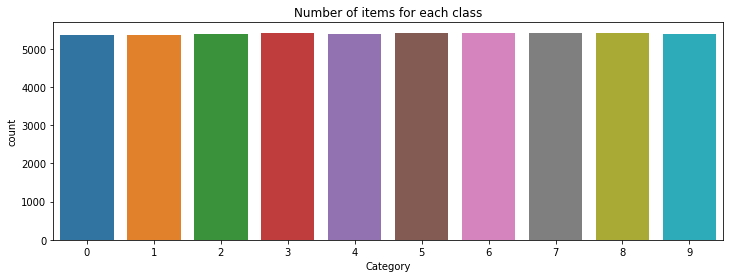

7(や):   5422 or 10.040740740740741%
5(は):   5422 or 10.040740740740741%
6(ま):   5421 or 10.03888888888889%
3(つ):   5408 or 10.014814814814816%
8(れ):   5403 or 10.005555555555555%
4(な):   5399 or 9.998148148148148%
9(を):   5395 or 9.99074074074074%
2(す):   5389 or 9.97962962962963%
0(お):   5374 or 9.951851851851853%
1(き):   5367 or 9.938888888888888%


In [18]:
def plot_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(ydf[0], order = np.arange(0,10))
    g.set_title("Number of items for each class")
    g.set_xlabel("Category")
            
    plt.show()  

def get_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    label_counts = ydf[0].value_counts()
    total_samples = len(yd)

    for i in range(len(label_counts)):
        label = label_counts.index[i]
        label_char = char_df[char_df['index']==label]['char'].item()
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{}({}):   {} or {}%".format(label, label_char, count, percent))
    
plot_count_per_class(np.argmax(y_train,axis=1))
get_count_per_class(np.argmax(y_train,axis=1))

Let's see also the class distribution of validation set.

/home/ninju/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


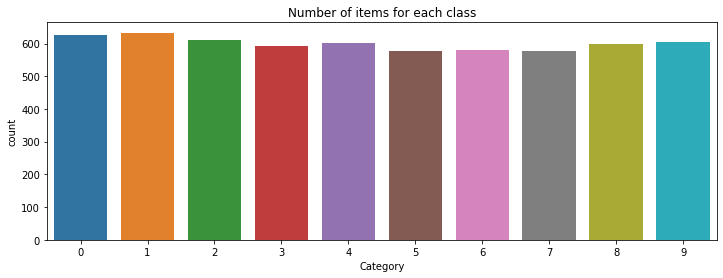

1(き):   633 or 10.549999999999999%
0(お):   626 or 10.433333333333334%
2(す):   611 or 10.183333333333334%
9(を):   605 or 10.083333333333332%
4(な):   601 or 10.016666666666667%
8(れ):   597 or 9.950000000000001%
3(つ):   592 or 9.866666666666667%
6(ま):   579 or 9.65%
5(は):   578 or 9.633333333333335%
7(や):   578 or 9.633333333333335%


In [19]:
plot_count_per_class(np.argmax(y_val,axis=1))
get_count_per_class(np.argmax(y_val,axis=1))

In [20]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation = 'relu', padding = "same",
        kernel_initializer = 'he_normal',input_shape = (IMG_ROWS, IMG_COLS, 1)))

model.add(BatchNormalization())

model.add(Conv2D(32,kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size = 5,strides = 2,padding = 'same',activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(64, kernel_size = (3, 3), strides = 2,padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = (3, 3), strides = 2,padding = 'same', activation = 'relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation = 'softmax'))

2022-04-08 12:48:56.841355: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-08 12:48:56.841472: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-08 12:48:56.841551: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hp-240-g7-notebook-pc): /proc/driver/nvidia/version does not exist
2022-04-08 12:48:56.869861: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 32)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 6, 32)          1

In [23]:
history = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=5,
          verbose=1,
          validation_data=(X_val, y_val))

2022-04-08 12:48:58.976801: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 169344000 exceeds 10% of free system memory.


Epoch 1/5


2022-04-08 12:49:09.110790: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 12845056 exceeds 10% of free system memory.
2022-04-08 12:49:09.440501: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 12845056 exceeds 10% of free system memory.
2022-04-08 12:49:09.812556: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25958400 exceeds 10% of free system memory.
2022-04-08 12:49:09.812716: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25958400 exceeds 10% of free system memory.


422/422 [==============================] - 133s 309ms/step - loss: 0.9268 - accuracy: 0.6948 - val_loss: 0.3013 - val_accuracy: 0.9018
Epoch 2/5
422/422 [==============================] - 129s 306ms/step - loss: 0.3706 - accuracy: 0.8898 - val_loss: 0.1515 - val_accuracy: 0.9545
Epoch 3/5
422/422 [==============================] - 129s 305ms/step - loss: 0.2765 - accuracy: 0.9178 - val_loss: 0.1247 - val_accuracy: 0.9635
Epoch 4/5
422/422 [==============================] - 130s 308ms/step - loss: 0.2274 - accuracy: 0.9335 - val_loss: 0.1035 - val_accuracy: 0.9688
Epoch 5/5
422/422 [==============================] - 130s 309ms/step - loss: 0.2005 - accuracy: 0.9414 - val_loss: 0.0939 - val_accuracy: 0.9698


In [33]:
predicted_classes = model.predict_classes(X_val)
y_true = np.argmax(y_val,axis=1)

/home/ninju/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:454: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [34]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [35]:
print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 5819
Incorrect predicted classes: 181


In [36]:
target_names = ["Class {} ({}):".format(i, char_df[char_df['index']==i]['char'].item()) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

Class 0 (お):       0.97      0.98      0.97       626
Class 1 (き):       0.98      0.98      0.98       633
Class 2 (す):       0.98      0.96      0.97       611
Class 3 (つ):       0.96      0.98      0.97       592
Class 4 (な):       0.97      0.96      0.96       601
Class 5 (は):       0.99      0.93      0.96       578
Class 6 (ま):       0.95      0.96      0.95       579
Class 7 (や):       0.98      0.99      0.98       578
Class 8 (れ):       0.96      0.97      0.96       597
Class 9 (を):       0.97      0.99      0.98       605

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



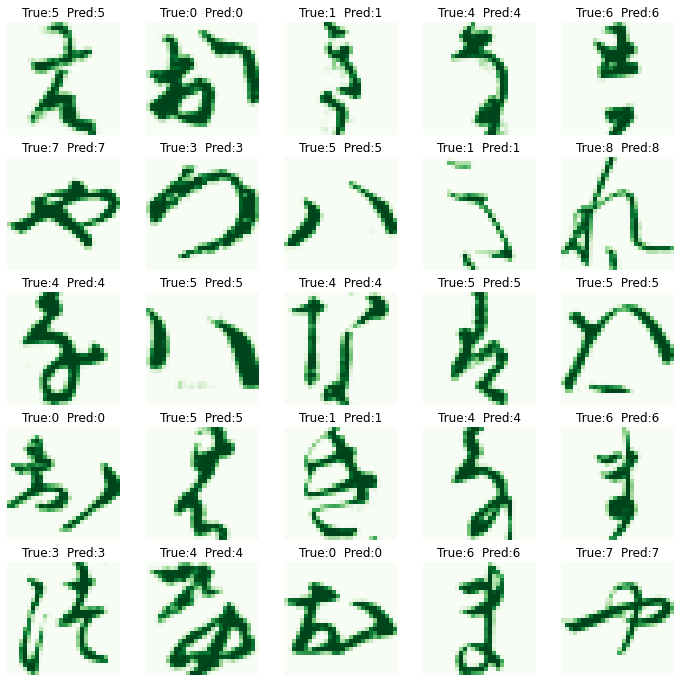

In [37]:
def plot_images(data_index,cmap="Blues"):
    f, ax = plt.subplots(5,5, figsize=(12,12))

    for i, indx in enumerate(data_index[:25]):
        ax[i//5, i%5].imshow(X_val[indx].reshape(IMG_ROWS,IMG_COLS), cmap=cmap)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("True:{}  Pred:{}".format(y_true[indx],predicted_classes[indx]))
    plt.show()    

plot_images(correct, "Greens")

Let's visualize the images from the validation set that were incorrecly classified (25 images).

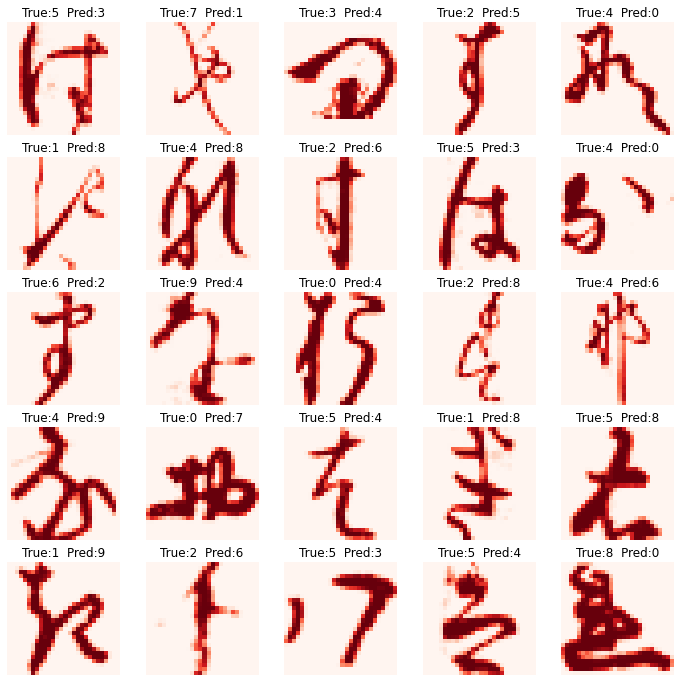

In [39]:
plot_images(incorrect, "Reds")

In [40]:
predicted_classes = model.predict_classes(X_test)
y_true = np.argmax(y_test,axis=1)
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]
print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])
target_names = ["Class {} ({}):".format(i, char_df[char_df['index']==i]['char'].item()) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

/home/ninju/miniconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:454: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Correct predicted classes: 9119
Incorrect predicted classes: 881
              precision    recall  f1-score   support

Class 0 (お):       0.94      0.95      0.94      1000
Class 1 (き):       0.93      0.92      0.92      1000
Class 2 (す):       0.92      0.85      0.89      1000
Class 3 (つ):       0.89      0.98      0.93      1000
Class 4 (な):       0.90      0.89      0.90      1000
Class 5 (は):       0.98      0.80      0.88      1000
Class 6 (ま):       0.85      0.94      0.89      1000
Class 7 (や):       0.93      0.92      0.92      1000
Class 8 (れ):       0.89      0.94      0.91      1000
Class 9 (を):       0.90      0.94      0.92      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



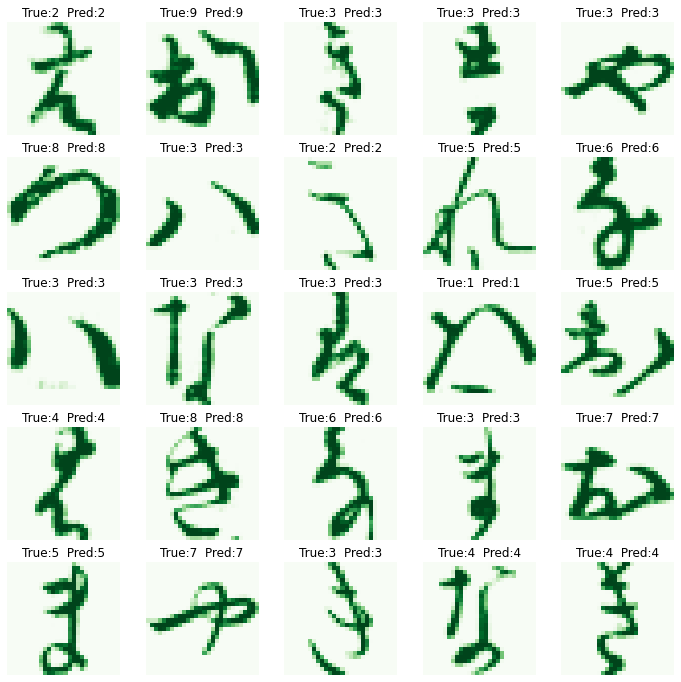

In [41]:
plot_images(correct, "Greens")

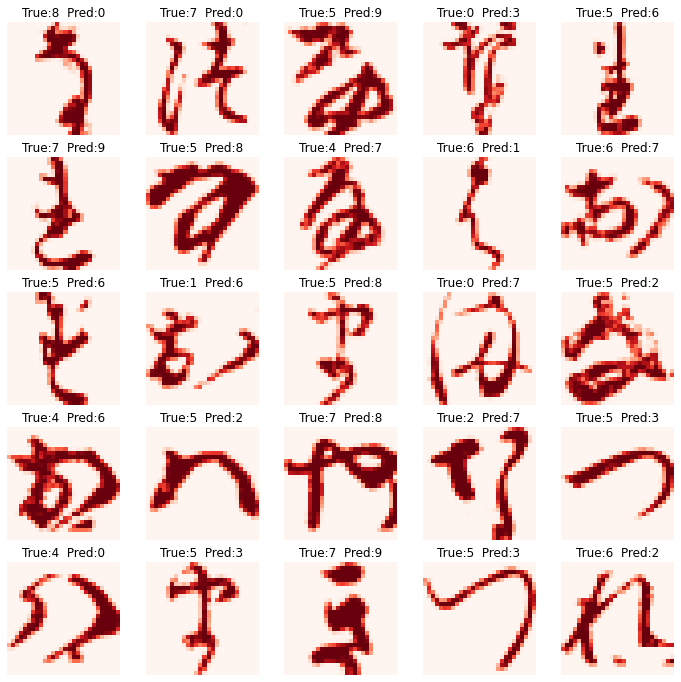

In [42]:
plot_images(incorrect, "Reds")